<a href="https://colab.research.google.com/github/George7531/for_machine_learning/blob/main/for_machine_learning/ml/Learnings/deep_learning_tool_kits/Deep_RL/Automatic_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# day 371

# Introduction
One of the most critical tasks in Deep Reinforcement Learning is to find a good set of training hyperparameters.
![fsfs](https://raw.githubusercontent.com/optuna/optuna/master/docs/image/optuna-logo.png)

Optuna is a library that helps you to automate the search.

## getting started:
* The content below comes from Antonin’s Raffin ICRA 2022 presentations, he’s one of the founders of Stable-Baselines and RL-Baselines3-Zoo.

## The theory behind Hyperparameter tuning:


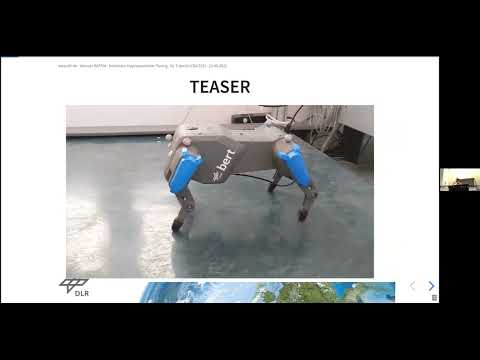

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('AidFTOdGNFQ')

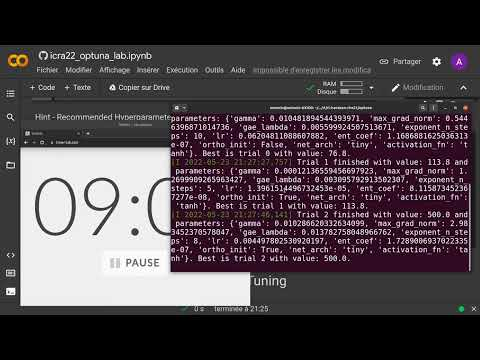

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('ihP7E76KGOI')

## Introduction

In this notebook, we will learn the importance of tuning hyperparameters. we will first try to optimize the parameters manually and then we will see how to automate the search using Optuna.



In [1]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

In [2]:
# Optional: install SB3 contrib to have access to additional algorithms
!pip install sb3-contrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 1.1 MB/s eta 0:00:00


In [3]:
# Optuna will be used in the last part when doing hyperparameter tuning
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00


In [4]:
import gym
import numpy as np

In [5]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DQN

In [6]:
# Algorithms from the contrib repo
# https://github.com/Stable-Baselines-Team/stable-baselines3-contrib
from sb3_contrib import QRDQN, TQC

In [7]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# Part I: The Importance Of Tuned Hyperparameters

When compared with Supervised Learning, Deep Reinforcement Learning is far more sensitive to the choice of hyper-parameters such as learning rate, number of neurons, number of layers, optimizer ... etc.

Poor choice of hyper-parameters can lead to poor/unstable convergence. This challenge is compounded by the variability in performance across random seeds (used to initialize the network weights and the environment).

In addition to hyperparameters, selecting the appropriate algorithm is also an important choice. We will demonstrate it on the simple Pendulum task.

See [gym doc](https://gym.openai.com/envs/Pendulum-v0/): "The inverted pendulum swingup problem is a classic problem in the control literature. In this version  of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright."


Let's try first with PPO and a small budget of 4000 steps (20 episodes):

In [8]:
env_id = "Pendulum-v1"
# Env used only for evaluation
eval_envs = make_vec_env(env_id, n_envs=10)
# 4000 training timesteps
budget_pendulum = 4000

In [9]:
ppo_model = PPO("MlpPolicy", env_id, seed=0, verbose=0).learn(budget_pendulum)

In [10]:
mean_reward, std_reward = evaluate_policy(ppo_model, eval_envs, n_eval_episodes=100, deterministic=True)

print(f"PPO Mean episode reward: {mean_reward:.2f} +/- {std_reward:.2f}")

PPO Mean episode reward: -1182.58 +/- 241.70


#A2C

In [11]:
# define and train a A2C model

A2C_model = A2C(policy='MlpPolicy',env=env_id,seed=0,verbose=0).learn(total_timesteps=budget_pendulum)

In [12]:
# Evaluate the train A2C model
mean_reward, std_reward = evaluate_policy(A2C_model,env=eval_envs,n_eval_episodes=100,deterministic=True)

print(f"A2C Mean episode reward: {mean_reward:.2f} +/- {std_reward:.2f}")

A2C Mean episode reward: -1193.83 +/- 177.68


Both are far from solving the env (mean reward around -200).
Now, let's try with an off-policy algorithm:

### Training longer PPO ?

Maybe training longer would help?

You can try with 10x the budget, but in the case of A2C/PPO, training longer won't help much, finding better hyperparameters is needed instead.

In [13]:
new_budget = 10*budget_pendulum

ppo_policy = PPO(policy='MlpPolicy',env=env_id,seed=0,verbose=0).learn(total_timesteps=new_budget)

In [14]:
mean_reward, std_reward = evaluate_policy(ppo_model, eval_envs, n_eval_episodes=100, deterministic=True)

print(f"PPO Mean episode reward: {mean_reward:.2f} +/- {std_reward:.2f}")

PPO Mean episode reward: -1179.19 +/- 231.44


### PPO - Tuned Hyperparameters

Using Optuna, we can in fact tune the hyperparameters and find a working solution (from the [RL Zoo](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/ppo.yml)):

In [15]:
tuned_params = {
    "gamma": 0.9,
    "use_sde": True,
    "sde_sample_freq": 4,
    "learning_rate": 1e-3,
}

# budget = 10 * budget_pendulum:
ppo_tuned_model = PPO("MlpPolicy", env_id, seed=1, verbose=1, **tuned_params).learn(50_000, log_interval=5)

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 200        |
|    ep_rew_mean          | -1.14e+03  |
| time/                   |            |
|    fps                  | 661        |
|    iterations           | 5          |
|    time_elapsed         | 15         |
|    total_timesteps      | 10240      |
| train/                  |            |
|    approx_kl            | 0.01470868 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.64      |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.001      |
|    loss                 | 17         |
|    n_updates            | 40         |
|    policy_gradient_loss | -0.0128    |
|    std                  | 0.88       |
|    value_loss           | 44.

In [16]:
mean_reward, std_reward = evaluate_policy(ppo_tuned_model, eval_envs, n_eval_episodes=100, deterministic=True)

print(f"Tuned PPO Mean episode reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Tuned PPO Mean episode reward: -195.42 +/- 213.49


# Part II: Grad Student Descent

### Challenge (10 minutes): "Grad Student Descent"
The challenge is to find the best hyperparameters (max performance) for A2C on `CartPole-v1` with a limited budget of 20 000 training steps.


Maximum reward: 500 on `CartPole-v1`

The hyperparameters should work for different random seeds.

In [17]:
budget = 20000

In [18]:
eval_envs_cartpole = make_vec_env('CartPole-v1',n_envs=10)

In [19]:
model = A2C('MlpPolicy',env='CartPole-v1',seed=8,verbose=0).learn(total_timesteps=budget)

In [20]:
mean_reward,std_reward = evaluate_policy(model,env=eval_envs_cartpole,n_eval_episodes=100,deterministic=True)

In [21]:
print('Mean Reward: {:.2f} \t Std Reward: {:.2f}'.format(mean_reward,std_reward))

Mean Reward: 463.58 	 Std Reward: 58.07


**Your goal is to beat that baseline and get closer to the optimal score of 500**

Time to tune!!!

Hint - Recommended Hyperparameter Range

```python
gamma = trial.suggest_float("gamma", 0.9, 0.99999, log=True)
max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
# from 2**3 = 8 to 2**10 = 1024
n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)
learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
# net_arch tiny: {"pi": [64], "vf": [64]}
# net_arch default: {"pi": [64, 64], "vf": [64, 64]}
# activation_fn = nn.Tanh / nn.ReLU
```

In [22]:
import torch.nn as nn

In [23]:
policy_kwargs = dict(
    net_arch=[
      dict(vf=[64, 64], pi=[64, 64]), # network architectures for actor/critic
    ],
    activation_fn=nn.Tanh, # tangent hyperbolic activation function
)

hyperparams = dict(
    n_steps=5, # number of steps to collect data before updating policy
    learning_rate=7e-4,
    gamma=0.99999, # discount factor
    max_grad_norm=0.5, # The maximum value for the gradient clipping
    ent_coef=0.0, # Entropy coefficient for the loss calculation
)

model = A2C("MlpPolicy", "CartPole-v1", seed=8, verbose=1, **hyperparams).learn(budget)

Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 26.2     |
|    ep_rew_mean        | 26.2     |
| time/                 |          |
|    fps                | 610      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.682   |
|    explained_variance | 0.403    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.87     |
|    value_loss         | 10.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 26.9     |
|    ep_rew_mean        | 26.9     |
| time/                 |          |
|    fps                | 529      |


In [24]:
mean_reward, std_reward = evaluate_policy(model, eval_envs_cartpole, n_eval_episodes=50, deterministic=True)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:500.00 +/- 0.00


Beautiful! we got our 500

# Part III: Automatic Hyperparameter Tuning

In this part we will create a script that allows to search for the best hyperparameters automatically.

In [25]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances

### Config

In [31]:
N_TRIALS = 15  # Maximum number of trials
N_JOBS = 1 # Number of jobs to run in parallel(jobs means CPU)
N_STARTUP_TRIALS = 5  # Stop random sampling after N_STARTUP_TRIALS
N_EVALUATIONS = 2  # Number of evaluations during the training
N_TIMESTEPS = int(2e4)  # Training budget
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_ENVS = 5
N_EVAL_EPISODES = 10
TIMEOUT = int(60 * 15)  # 15 minutes

ENV_ID = "CartPole-v1"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}

In [26]:
from typing import Any, Dict
import torch
import torch.nn as nn

def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for A2C hyperparameters.

    :param trial: Optuna trial object
    :return: The sampled hyperparameters for the given trial.
    """
    # Discount factor between 0.9 and 0.9999
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
    # 8, 16, 32, ... 1024
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)

    ### YOUR CODE HERE
    # TODO:
    # - define the learning rate search space [1e-5, 1] (log) -> `suggest_float`
    # - define the network architecture search space ["tiny", "small"] -> `suggest_categorical`
    # - define the activation function search space ["tanh", "relu"]
    learning_rate = trial.suggest_float("learning_rate",1e-5,1,log=True)
    net_arch = trial.suggest_categorical('net_arch',['tiny','small'])
    activation_fn = trial.suggest_categorical('activation_fn',['tanh','relu'])

    ### END OF YOUR CODE

    # Display true values
    trial.set_user_attr("gamma_", gamma)
    trial.set_user_attr("n_steps", n_steps)

    net_arch = [
        {"pi": [64], "vf": [64]}
        if net_arch == "tiny"
        else {"pi": [64, 64], "vf": [64, 64]}
    ]

    activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

    return {
        "n_steps": n_steps,
        "gamma": gamma,
        "learning_rate": learning_rate,
        "max_grad_norm": max_grad_norm,
        "policy_kwargs": {
            "net_arch": net_arch,
            "activation_fn": activation_fn,
        },
    }

### Define the objective function

First we define a custom callback to report the results of periodic evaluations to Optuna:

In [27]:
from stable_baselines3.common.callbacks import EvalCallback

class TrialEvalCallback(EvalCallback):
    """
    Callback used for evaluating and reporting a trial.

    :param eval_env: Evaluation environement
    :param trial: Optuna trial object
    :param n_eval_episodes: Number of evaluation episodes
    :param eval_freq:   Evaluate the agent every ``eval_freq`` call of the callback.
    :param deterministic: Whether the evaluation should
        use a stochastic or deterministic policy.
    :param verbose:
    """

    def __init__(
        self,
        eval_env: gym.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):

        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            # Evaluate policy (done in the parent class)
            super()._on_step()
            self.eval_idx += 1
            # Send report to Optuna
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True

### Exercise (10 minutes): Define the objective function

In [29]:
def objective(trial: optuna.Trial) -> float:
    """
    Objective function using by Optuna to evaluate
    one configuration (i.e., one set of hyperparameters).

    Given a trial object, it will sample hyperparameters,
    evaluate it and report the result (mean episodic reward after training)

    :param trial: Optuna trial object
    :return: Mean episodic reward after training
    """

    kwargs = DEFAULT_HYPERPARAMS.copy()
    ### YOUR CODE HERE
    # TODO:
    # 1. Sample hyperparameters and update the default keyword arguments: `kwargs.update(other_params)`
    # 2. Create the evaluation envs
    # 3. Create the `TrialEvalCallback`

    # 1. Sample hyperparameters and update the keyword arguments
    kwargs.update(sample_a2c_params(trial))

    # Create the RL model:
    model = A2C(**kwargs)

    # 2. Create envs used for evaluation using `make_vec_env`, `ENV_ID` and `N_EVAL_ENVS`
    eval_envs = make_vec_env(ENV_ID,N_EVAL_ENVS)



    # 3. Create the `TrialEvalCallback` callback defined above that will periodically evaluate
    # and report the performance using `N_EVAL_EPISODES` every `EVAL_FREQ`
    # TrialEvalCallback signature:
    # TrialEvalCallback(eval_env, trial, n_eval_episodes, eval_freq, deterministic, verbose)
    eval_callback = TrialEvalCallback(eval_envs,
                                      trial,
                                      N_EVAL_EPISODES,
                                      EVAL_FREQ,
                                      deterministic=True)

    ### END OF YOUR CODE

    nan_encountered = False
    try:
        # Train the model
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN
        print(e)
        nan_encountered = True
    finally:
        # Free memory
        model.env.close()
        eval_envs.close()

    # Tell the optimizer that the trial failed
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward

# The optimization loop:

In [30]:
import torch as th

# Set pytorch num threads to 1 for faster training
th.set_num_threads(1)
# Select the sampler, can be random, TPESampler, CMAES, ...
sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
# Do not prune before 1/3 of the max budget is used
pruner = MedianPruner(
    n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3
)
# Create the study and start the hyperparameter optimization
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")

try:
    study.optimize(objective, n_trials=N_TRIALS, n_jobs=N_JOBS, timeout=TIMEOUT)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print(f"    {key}: {value}")

# Write report
study.trials_dataframe().to_csv("study_results_a2c_cartpole.csv")

fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)

fig1.show()
fig2.show()

[I 2024-05-27 15:00:22,699] A new study created in memory with name: no-name-ecb02bc1-6b23-49ca-ad36-89fb5903c2fd
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
[I 2024-05-27 15:00:41,571] Trial 0 finished with value: 94.1 and parameters: {'gamma': 0.004994863740730417, 'max_grad_norm': 0.47919052007282054, 'exponent_n_steps': 8, 'learning_rate': 5.45241449729672e-05, 'net_arch': 'tiny', 'activation_fn': 'tanh'}. Best is trial 0 with value: 94.1.
[I 2024-05-27 15:01:04,432] Trial 1 finished with value: 72.9 and parameters: {'gamma': 0.009494159301665028, 'max_grad_norm': 3.137777720375301, 'exponent_n_steps': 5, 'learning_rate': 2.616255955924514e-05, 'net_arch': 'small', 'activation_fn': 'relu'}. Best is trial 0 with value: 

Number of finished trials:  15
Best trial:
  Value: 500.0
  Params: 
    gamma: 0.0018491118872518608
    max_grad_norm: 1.2959090630337564
    exponent_n_steps: 8
    learning_rate: 0.0043489062913765215
    net_arch: tiny
    activation_fn: tanh
  User attrs:
    gamma_: 0.9981508881127481
    n_steps: 256
